# `kelp` with `theano`

In this notebook, we will test the capability of `kelp` with `theano`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from kelp import Planet, Filter
from kelp.theano import reflected_phase_curve, thermal_phase_curve
from kelp.theano import reflected_phase_curve_inhomogeneous

In [2]:
# Needed planetary parameters
per=2.7240330
t0=2458926.5416960
inc=84.03
rp=0.069577
ecc=0.
a=4.60
u=[0.414, 0.155]
fp=9.65e-5
t_secondary=2458927.9037125
T_s=8000.
rp_a=0.015168

Let's also compute an eclipse-transit model

In [3]:
phs = np.linspace(0.01, 0.99, 1000)

pars = batman.TransitParams()
pars.t0 = 0.
pars.per = 1.#per
pars.rp = rp
pars.a = a
pars.inc = inc
pars.ecc = ecc
pars.w = 90.
pars.limb_dark = 'quadratic'
pars.u = u
pars.fp = fp
pars.t_secondary = 0.5

m1 = batman.TransitModel(pars, phs, transittype='secondary')
m2 = batman.TransitModel(pars, phs)
flx_ecl = m1.light_curve(pars)
flx_tra = m2.light_curve(pars)

flx_both = flx_ecl*flx_tra

In [4]:
## Creating a Planet Object
plan = Planet(per=per,\
     t0=t0,\
     inc=inc,\
     rp=rp,\
     ecc=ecc,\
     w=None,\
     a=a,\
     u=u,\
     fp=fp,\
     t_secondary=t_secondary,\
     T_s=T_s,\
     rp_a=rp_a, limb_dark='quadratic', name='WASP-189')

fltr = Filter.from_name('CHEOPS')

### Reflection phase curve (symmetric version)

The geometric albedo is:  0.04581407018001122
The integral phase function is:  1.619996980663244


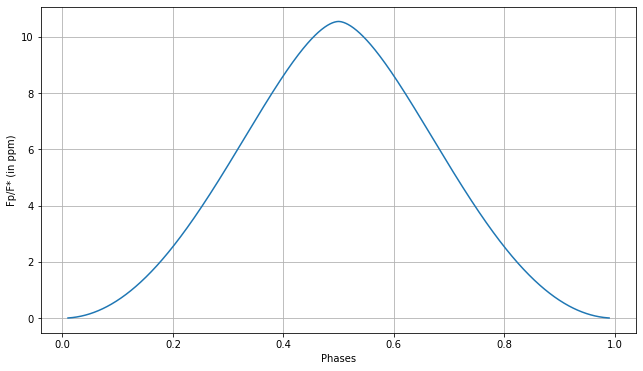

In [5]:
ref1, ag1, q1 = reflected_phase_curve(phases=phs, omega=0.3, g=0., a_rp=1/rp_a)

print('The geometric albedo is: ', ag1.eval())
print('The integral phase function is: ', q1.eval())

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(phs, ref1.eval())
plt.xlabel('Phases')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()

Along with eclipse-transit model...

(1.0, 1.00012)

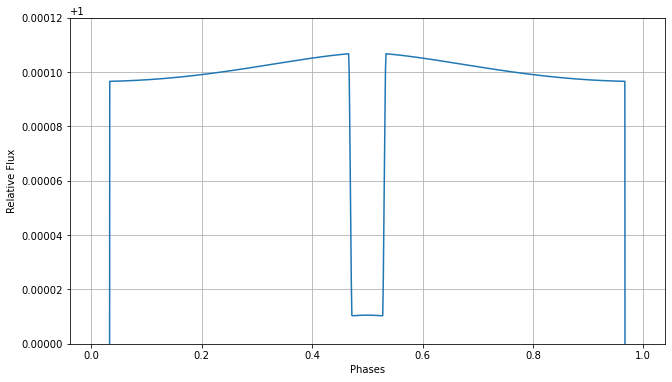

In [6]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(phs, flx_both + (ref1.eval()/1e6))
plt.xlabel('Phases')
plt.ylabel('Relative Flux')
plt.grid()
plt.ylim([1.0000, 1.00012])

### Reflection light curve (asymmetric version)

(1.00005, 1.000175)

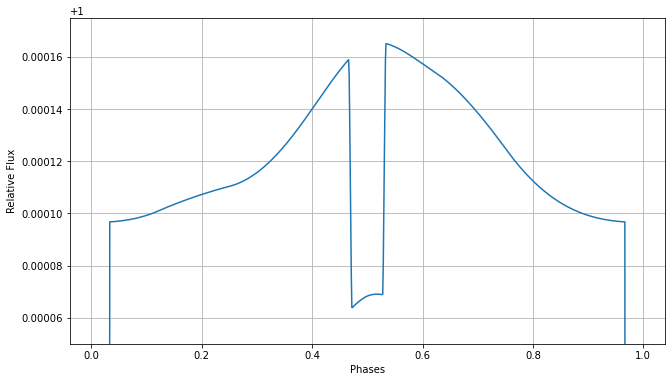

In [7]:
ref2, g2, q2 = reflected_phase_curve_inhomogeneous(phases=phs, omega_0=0.01, omega_prime=0.95, x1=0., x2=0.8, A_g=0.3, a_rp=1/rp_a)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(phs, flx_both + (ref2.eval()/1e6))
plt.xlabel('Phases')
plt.ylabel('Relative Flux')
plt.grid()
plt.ylim([1.00005, 1.000175])

### Thermal phase curve

This could be the trickiest of above, let's see.

Note that the output curve would NOT be in the units of ppm.

(1.00002, 1.00016)

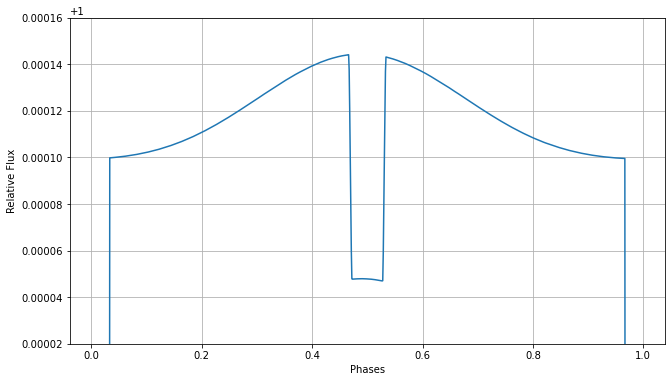

In [29]:
phi = np.linspace(-2 * np.pi, 2 * np.pi, 100, dtype='float64')
theta = np.linspace(0, np.pi, 100, dtype='float64')
theta2d, phi2d = np.meshgrid(theta, phi)

import astropy.units as u

filt_wavelength, filt_trans = fltr.wavelength.to(u.m).value, fltr.transmittance

the1, tmap = thermal_phase_curve(xi=2*np.pi*(phs-0.5),\
     hotspot_offset=-0.12043, omega_drag=4.5, alpha=0.6, C_11=0.18, T_s=T_s, a_rs=a, rp_a=rp_a,\
     A_B=0., theta2d=theta2d, phi2d=phi2d, filt_wavelength=filt_wavelength, filt_transmittance=filt_trans,\
     f=1/np.sqrt(2), stellar_spectrum_wavelength=None, stellar_spectrum_spectral_flux_density=None)


plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(phs, flx_both + the1.eval())
plt.xlabel('Phases')
plt.ylabel('Relative Flux')
plt.grid()
plt.ylim([1.00002, 1.00016])

And the temperature map,

In [30]:
tmap.eval()[:,:,0,0].shape

(100, 100)

In [31]:
theta2d.shape

(100, 100)

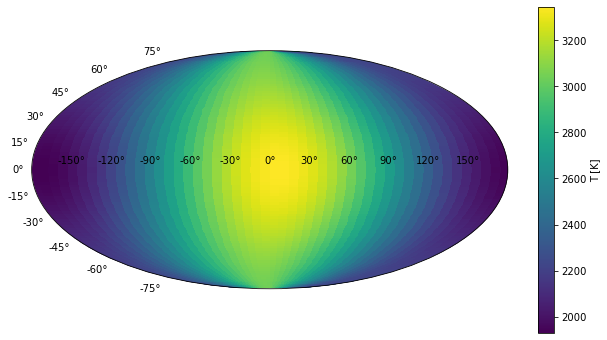

In [32]:
# Plot the temperature map
fig = plt.figure(figsize=(16/1.5,9/1.5))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.pcolormesh(phi2d, theta2d - np.pi/2, tmap.eval()[:,:,0,0], shading='auto')
plt.colorbar(cax, label='T [K]')
plt.show()